In [548]:
import os
import shutil
import sys
import json
import argparse
import numpy as np
import math
from einops import rearrange
import time
import random
import string
from tqdm import tqdm
import re
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import transforms
import imageio
import pandas as pd
import glob

In [554]:
def get_images(prefix, folder_path="all_stimuli/"):
    search_pattern = os.path.join(folder_path, prefix)
    image_files = glob.glob(search_pattern)
    return image_files

def seed_everything(seed=0, cudnn_deterministic=True):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
p_id = 1 # participant ID
print("p_id", p_id)
sess_num = 3
print("sess_num", sess_num)
    
seed_everything(int(f"{p_id}{sess_num}"))
print(f"seeded with rng seed {p_id}{sess_num}")

p_id 1
sess_num 3
seeded with rng seed 13


In [555]:
if sess_num == 2:
    all_images = [
        get_images("MST_pairs1/*"),
        get_images("MST_pairs1/*"),
        get_images("MST_pairs1/*"),
        get_images("special515/*")[:100],
        get_images("special515/*")[:100],
        get_images("special515/*")[:100],
        get_images("special515/*")[200:515],
        get_images("shared1000_notspecial/*")[:85],
        get_images("closest_pairs1/*"),
        get_images("unchosen_nsd_1000_images/*")[:83],
    ]
elif sess_num == 3:
    all_images = [
        get_images("MST_pairs2/*"),
        get_images("MST_pairs2/*"),
        get_images("MST_pairs2/*"),
        get_images("special515/*")[100:200],
        get_images("special515/*")[100:200],
        get_images("special515/*")[100:200],
        get_images("shared1000_notspecial/*")[85:485],
        get_images("closest_pairs2/*"),
        get_images("unchosen_nsd_1000_images/*")[83:83+83],
    ]

In [556]:
# flatten
all_images_flattened = [item for sublist in all_images for item in sublist]
print(len(all_images_flattened))

# prevent back-to-back repeats
while True:
    all_images_shuffled = np.random.permutation(all_images_flattened)
    if all(all_images_shuffled[i] != all_images_shuffled[i + 1] for i in range(len(all_images_shuffled) - 1)):
        break

all_images_shuffled[:10]

1008


array(['all_stimuli/special515/special_40909.jpg',
       'all_stimuli/closest_pairs2/set_3_closest_to_pair_37_image_cocoid_45923.png',
       'all_stimuli/special515/special_71232.jpg',
       'all_stimuli/special515/special_3856.jpg',
       'all_stimuli/special515/special_6444.jpg',
       'all_stimuli/closest_pairs2/set_3_closest_to_pair_27_image_cocoid_44058.png',
       'all_stimuli/special515/special_65872.jpg',
       'all_stimuli/closest_pairs2/set_1_closest_to_pair_25_image_cocoid_58252.png',
       'all_stimuli/MST_pairs2/pair_27_nsd_505_2_cocoid_31968.png',
       'all_stimuli/special515/special_3682.jpg'], dtype='<U74')

In [557]:
num_runs_total = 16
print("num_runs_total", num_runs_total)
trials_per_run = 70
print("trials_per_run", trials_per_run)
blanks_per_run = 7
print("blanks_per_run", blanks_per_run)

total_trials = (trials_per_run * num_runs_total)
print("\ntotal_trials", total_trials)
print("total_trials_no_blanks", total_trials - (blanks_per_run * num_runs_total))

print("\ntotal_trials_per_run", total_trials / num_runs_total)
print("total_trials_no_blanks_per_run", (total_trials - (blanks_per_run * num_runs_total))/ num_runs_total)

print("\nseconds_per_run", (total_trials / num_runs_total) * 4)
# there are 2 blanks at end of every run instead of adding a novel end-of-run blank period

assert len(all_images_shuffled) == ((trials_per_run - blanks_per_run) * num_runs_total)

# trials_per_run = 4
# blanks_per_run = 2
# all_images_shuffled = all_images_shuffled[:32]
# run_to_blanks = [[2,3] for r in range(num_runs_total)]

run_to_blanks = [[9, 21, 31, 45, 56, 68, 69] for r in range(num_runs_total)]
run_to_blanks

num_runs_total 16
trials_per_run 70
blanks_per_run 7

total_trials 1120
total_trials_no_blanks 1008

total_trials_per_run 70.0
total_trials_no_blanks_per_run 63.0

seconds_per_run 280.0


[[9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69],
 [9, 21, 31, 45, 56, 68, 69]]

In [558]:
participant_path = "conditions_files/participant" + str(p_id)
os.makedirs("conditions_files",exist_ok=True)

num_repeats = 0
image_index = 0
current_image_list_cumulative = []
for run_num in range(num_runs_total):
    current_image_list = []
    is_repeat_list = []
    run_num_list = []
    is_new_run_list = []
    is_blank_trial_list = []
    trial_index_list = []
    all_blanks_list_list = []
    is_not_last_trial_list = []
    sess_num_list = []

    blank_trial_indices = run_to_blanks[run_num]
    for trial_index in range(trials_per_run):
        run_num_list.append(run_num)
        sess_num_list.append(sess_num)
        all_blanks_list_list.append(blank_trial_indices)
        trial_index_list.append(trial_index)

        if trial_index == trials_per_run-1:
            is_not_last_trial_list.append(0)
        else:
            is_not_last_trial_list.append(1)

        if trial_index == (trials_per_run - 1) and run_num != (num_runs_total - 1):
            is_new_run_list.append(1)
        else:
            is_new_run_list.append(0)

        if trial_index in blank_trial_indices:
            current_image_list.append("blank.jpg")
            previous_image = "blank"
            is_blank_trial_list.append(1)
            is_repeat_list.append(0)
        else:
            image_path = all_images_shuffled[image_index]
            if image_path in current_image_list_cumulative:
                is_repeat_list.append(1)
                num_repeats += 1
            else:
                is_repeat_list.append(0)
            current_image_list.append(image_path)
            current_image_list_cumulative.append(image_path)
            is_blank_trial_list.append(0)
            previous_image = image_path.split("__")[-1].split(".jpg")[0].replace("_","\n")

            image_index += 1
            
    # output study and test
    output_dict = {"current_image": current_image_list,
                   "is_repeat": is_repeat_list,
                   "trial_index": trial_index_list,
                   "is_blank_trial":is_blank_trial_list,
                   "is_new_run": is_new_run_list,
                   "run_num": run_num_list,
                   "sess_num": sess_num_list,
                   "is_not_last_trial": is_not_last_trial_list,
                   "all_blanks_list": all_blanks_list_list}
    output_df = pd.DataFrame(output_dict)
    study_test_file_path = participant_path + "_run" + str(run_num) + "_sess" + str(sess_num) + ".csv"
    output_df.to_csv(study_test_file_path, index = False)
    
    print("num_repeats", num_repeats)

num_repeats 3
num_repeats 9
num_repeats 17
num_repeats 30
num_repeats 48
num_repeats 59
num_repeats 76
num_repeats 101
num_repeats 122
num_repeats 143
num_repeats 166
num_repeats 186
num_repeats 217
num_repeats 240
num_repeats 272
num_repeats 300


# special512 conversion

In [ ]:
err

In [545]:
# import os
# import re

# # Define the folder path
# folder_path = 'all_stimuli/closest_pairs1'

# # Define the regex pattern to match filenames with odd numbers
# pattern = re.compile(r'pair_(\d+)_image')

# # Loop through all files in the folder
# for filename in os.listdir(folder_path):
#     match = pattern.search(filename)
#     if match:
#         number = int(match.group(1))
#         if number % 2 != 0:  # Check if the number is odd
#             file_path = os.path.join(folder_path, filename)
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")

In [547]:
# import os
# import re

# # Define the folder path
# folder_path = 'all_stimuli/closest_pairs2'

# # Define the regex pattern to match filenames with numbers
# pattern = re.compile(r'pair_(\d+)_image')

# # Loop through all files in the folder
# for filename in os.listdir(folder_path):
#     match = pattern.search(filename)
#     if match:
#         number = int(match.group(1))
#         if number % 2 == 0:  # Check if the number is even
#             file_path = os.path.join(folder_path, filename)
#             os.remove(file_path)
#             print(f"Deleted: {file_path}")

In [536]:
nsd_stim = pd.read_csv("all_stimuli/nsd_stim_info_merged.csv")

In [537]:
cocoids = nsd_stim['cocoId'].values
nsdids = nsd_stim['nsdId'].values # zero-index
shared1000 = nsd_stim['shared1000'].values

In [284]:
np.where(shared1000==True)

(array([ 2950,  2990,  3049,  3077,  3146,  3157,  3164,  3171,  3181,
         3386,  3434,  3449,  3489,  3626,  3682,  3687,  3729,  3809,
         3842,  3847,  3856,  3913,  3951,  4051,  4058,  4129,  4156,
         4249,  4325,  4423,  4436,  4612,  4667,  4690,  4768,  4786,
         4835,  4869,  4892,  4930,  5034,  5106,  5204,  5285,  5301,
         5338,  5427,  5459,  5502,  5542,  5574,  5583,  5602,  5714,
         5878,  5890,  6132,  6199,  6222,  6431,  6444,  6489,  6514,
         6521,  6524,  6558,  6640,  6713,  6801,  7007,  7039,  7120,
         7207,  7336,  7366,  7409,  7418,  7480,  7654,  7659,  7840,
         7859,  7944,  7948,  7954,  8006,  8109,  8204,  8225,  8262,
         8274,  8318,  8387,  8394,  8415,  8435,  8465,  8509,  8631,
         8646,  8807,  8843,  8925,  8933,  9027,  9048,  9147,  9230,
         9434,  9462,  9680,  9722,  9804,  9847,  9865,  9917,  9978,
        10006, 10046, 10064, 10105, 10107, 10244, 10393, 10471, 10507,
      

In [231]:
import os

# Specify the directory containing the jpg files
folder_path = 'all_stimuli/special515copy'

# Get a list of all .jpg files in the directory
jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

nsdids_515 = np.array([])

# Loop through the files and rename them
for index, filename in enumerate(jpg_files):
    nsdid_ = np.where(cocoids==int(filename.split(".")[0]))[0].item()
    
    # Define the new filename
    new_filename = f"special_{nsdid_}.jpg"
    
    # Construct the full file paths
    old_file_path = os.path.join(folder_path, filename)
    new_file_path = os.path.join(folder_path, new_filename)
    
    nsdids_515 = np.append(nsdids_515, nsdid_)
    
    # Rename the file
    # os.rename(old_file_path, new_file_path)

print("Renaming complete!")
nsdids_515 = nsdids_515.astype(np.int32)

Renaming complete!


In [346]:
# [float(f.split("cocoid_")[-1].split(".")[0]) for f in os.listdir(folder_path) if f.endswith('.png')]

In [368]:
shared1000images = images[np.where(shared1000)[0]]
shared1000images.shape

(1000, 3, 224, 224)

In [376]:
shared1000images.max()

1.0

In [370]:
sharednsdid = np.where(shared1000)[0]

In [389]:
from PIL import Image
save_folder = 'all_stimuli/shared1000_notspecial'
cnt = 0
# Loop through the files in the directory
for ii,id in enumerate(sharednsdid):
    if ~np.any(id == nsdids_515):
        cnt +=1
        image_array = shared1000images[ii]
        
        # Transpose the array from (3, 224, 224) to (224, 224, 3) to match image format
        image_array = image_array.transpose(1, 2, 0)

        # Convert the float16 array to uint8 format for saving as PNG
        image_array = (image_array * 255).astype(np.uint8)

        # Convert the NumPy array to a PIL image
        image = Image.fromarray(image_array)

        # Save the image as a PNG file
        image.save(os.path.join(save_folder, f'notspecial_{id}.png'))
        
print(cnt)

485


In [412]:
folder_path = 'all_stimuli/shared_nsd_1000_images'
ps = []
for file in os.listdir(folder_path):
    if file[-4:]!=".png" and file[-4:]!=".jpg" and file[-5:]!=".jpeg":
        continue
    else:
        p = file.split("cocoid_")[-1].split(".png")[0]
        ps = np.append(ps, p)
        if int(p) == 10006:
            print(file)
print(len(ps))
print(len(np.unique(ps)))

shared_522_cocoid_10006.png
shared_313_cocoid_10006.png
shared_551_cocoid_10006.png
1000
631


In [403]:
unique, counts = np.unique(ps, return_counts=True)
duplicates = unique[counts > 1]
duplicates

array(['10006', '10046', '10064', '10107', '10244', '10471', '11159',
       '11521', '11617', '11689', '11725', '11796', '11942', '11952',
       '12308', '12796', '12798', '13138', '13312', '13314', '13613',
       '14528', '14594', '14644', '14793', '14820', '15819', '15939',
       '16252', '16344', '16702', '16723', '16823', '16917', '17238',
       '17549', '18434', '18543', '19074', '19181', '19199', '19200',
       '19292', '19933', '20080', '20442', '20633', '20650', '21192',
       '21279', '21601', '22263', '22523', '22530', '22587', '22782',
       '22879', '22967', '23036', '23715', '24202', '24517', '25111',
       '25287', '25318', '25581', '26119', '26163', '26292', '26435',
       '26598', '26720', '26990', '27242', '27326', '27435', '27580',
       '27830', '28024', '28068', '28096', '28159', '28319', '28349',
       '28524', '28595', '28751', '29381', '29886', '30081', '30373',
       '30395', '30407', '30430', '30601', '30672', '3077', '30847',
       '31028', '3123

In [170]:
import h5py
f = h5py.File('all_stimuli/coco_images_224_float16.hdf5', 'r')
images = f['images']

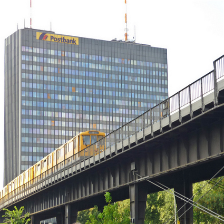

In [273]:
transforms.ToPILImage()(torch.Tensor(images[28487]))

In [225]:
nsd_stim.shared1000

0        False
1        False
2        False
3        False
4        False
         ...  
72995    False
72996    False
72997    False
72998    False
72999    False
Name: shared1000, Length: 73000, dtype: bool